
# Poisson regression and non-normal loss

This example illustrates the use of log-linear Poisson regression on the
[French Motor Third-Party Liability Claims dataset](https://www.openml.org/d/41214) from [1]_ and compares it with a linear
model fitted with the usual least squared error and a non-linear GBRT model
fitted with the Poisson loss (and a log-link).

A few definitions:

- A **policy** is a contract between an insurance company and an individual:
  the **policyholder**, that is, the vehicle driver in this case.

- A **claim** is the request made by a policyholder to the insurer to
  compensate for a loss covered by the insurance.

- The **exposure** is the duration of the insurance coverage of a given policy,
  in years.

- The claim **frequency** is the number of claims divided by the exposure,
  typically measured in number of claims per year.

In this dataset, each sample corresponds to an insurance policy. Available
features include driver age, vehicle age, vehicle power, etc.

Our goal is to predict the expected frequency of claims following car accidents
for a new policyholder given the historical data over a population of
policyholders.

.. [1]  A. Noll, R. Salzmann and M.V. Wuthrich, Case Study: French Motor
    Third-Party Liability Claims (November 8, 2018). [doi:10.2139/ssrn.3164764](https://doi.org/10.2139/ssrn.3164764)


In [2]:
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## The French Motor Third-Party Liability Claims dataset

Let's load the motor claim dataset from OpenML:
https://www.openml.org/d/41214



In [3]:
from sklearn.datasets import fetch_openml

df = fetch_openml(data_id=41214, as_frame=True).frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


The number of claims (``ClaimNb``) is a positive integer that can be modeled
as a Poisson distribution. It is then assumed to be the number of discrete
events occurring with a constant rate in a given time interval (``Exposure``,
in units of years).

Here we want to model the frequency ``y = ClaimNb / Exposure`` conditionally
on ``X`` via a (scaled) Poisson distribution, and use ``Exposure`` as
``sample_weight``.



Average Frequency = 0.10070308464041305
Fraction of exposure with zero claims = 93.9%


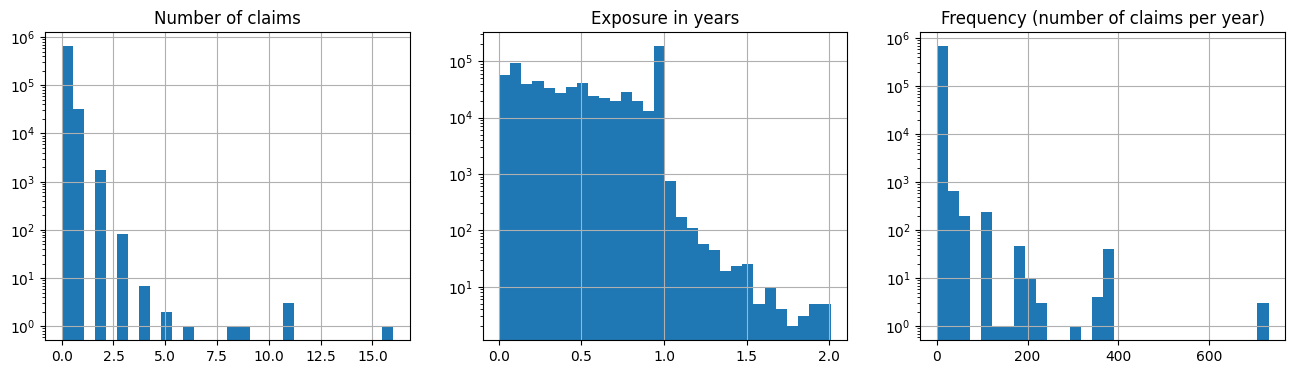

In [4]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

The remaining columns can be used to predict the frequency of claim events.
Those columns are very heterogeneous with a mix of categorical and numeric
variables with different scales, possibly very unevenly distributed.

In order to fit linear models with those predictors it is therefore
necessary to perform standard feature transformations as follows:



In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        (
            "binned_numeric",
            KBinsDiscretizer(
                n_bins=10, quantile_method="averaged_inverted_cdf", random_state=0
            ),
            ["VehAge", "DrivAge"],
        ),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

## A constant prediction baseline

It is worth noting that more than 93% of policyholders have zero claims. If
we were to convert this problem into a binary classification task, it would
be significantly imbalanced, and even a simplistic model that would only
predict mean can achieve an accuracy of 93%.

To evaluate the pertinence of the used metrics, we will consider as a
baseline a "dummy" estimator that constantly predicts the mean frequency of
the training sample.



In [6]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

Let's compute the performance of this constant prediction baseline with 3
different regression metrics:



In [7]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_poisson_deviance,
    mean_squared_error,
)


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


## (Generalized) linear models

We start by modeling the target variable with the (l2 penalized) least
squares linear regression model, more commonly known as Ridge regression. We
use a low penalization `alpha`, as we expect such a linear model to under-fit
on such a large dataset.



In [8]:
from sklearn.linear_model import Ridge

ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

The Poisson deviance cannot be computed on non-positive values predicted by
the model. For models that do return a few non-positive predictions (e.g.
:class:`~sklearn.linear_model.Ridge`) we ignore the corresponding samples,
meaning that the obtained Poisson deviance is approximate. An alternative
approach could be to use :class:`~sklearn.compose.TransformedTargetRegressor`
meta-estimator to map ``y_pred`` to a strictly positive domain.



In [9]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.597


Next we fit the Poisson regressor on the target variable. We set the
regularization strength ``alpha`` to approximately 1e-6 over number of
samples (i.e. `1e-12`) in order to mimic the Ridge regressor whose L2 penalty
term scales differently with the number of samples.

Since the Poisson regressor internally models the log of the expected target
value instead of the expected value directly (log vs identity link function),
the relationship between X and y is not exactly linear anymore. Therefore the
Poisson regressor is called a Generalized Linear Model (GLM) rather than a
vanilla linear model as is the case for Ridge regression.



In [10]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, solver="newton-cholesky")),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


## Gradient Boosting Regression Trees for Poisson regression

Finally, we will consider a non-linear model, namely Gradient Boosting
Regression Trees. Tree-based models do not require the categorical data to be
one-hot encoded: instead, we can encode each category label with an arbitrary
integer using :class:`~sklearn.preprocessing.OrdinalEncoder`. With this
encoding, the trees will treat the categorical features as ordered features,
which might not be always a desired behavior. However this effect is limited
for deep enough trees which are able to recover the categorical nature of the
features. The main advantage of the
:class:`~sklearn.preprocessing.OrdinalEncoder` over the
:class:`~sklearn.preprocessing.OneHotEncoder` is that it will make training
faster.

Gradient Boosting also gives the possibility to fit the trees with a Poisson
loss (with an implicit log-link function) instead of the default
least-squares loss. Here we only fit trees with the Poisson loss to keep this
example concise.



In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.562
MAE: 0.184
mean Poisson deviance: 0.577


Like the Poisson GLM above, the gradient boosted trees model minimizes
the Poisson deviance. However, because of a higher predictive power,
it reaches lower values of Poisson deviance.

Evaluating models with a single train / test split is prone to random
fluctuations. If computing resources allow, it should be verified that
cross-validated performance metrics would lead to similar conclusions.

The qualitative difference between these models can also be visualized by
comparing the histogram of observed target values with that of predicted
values:



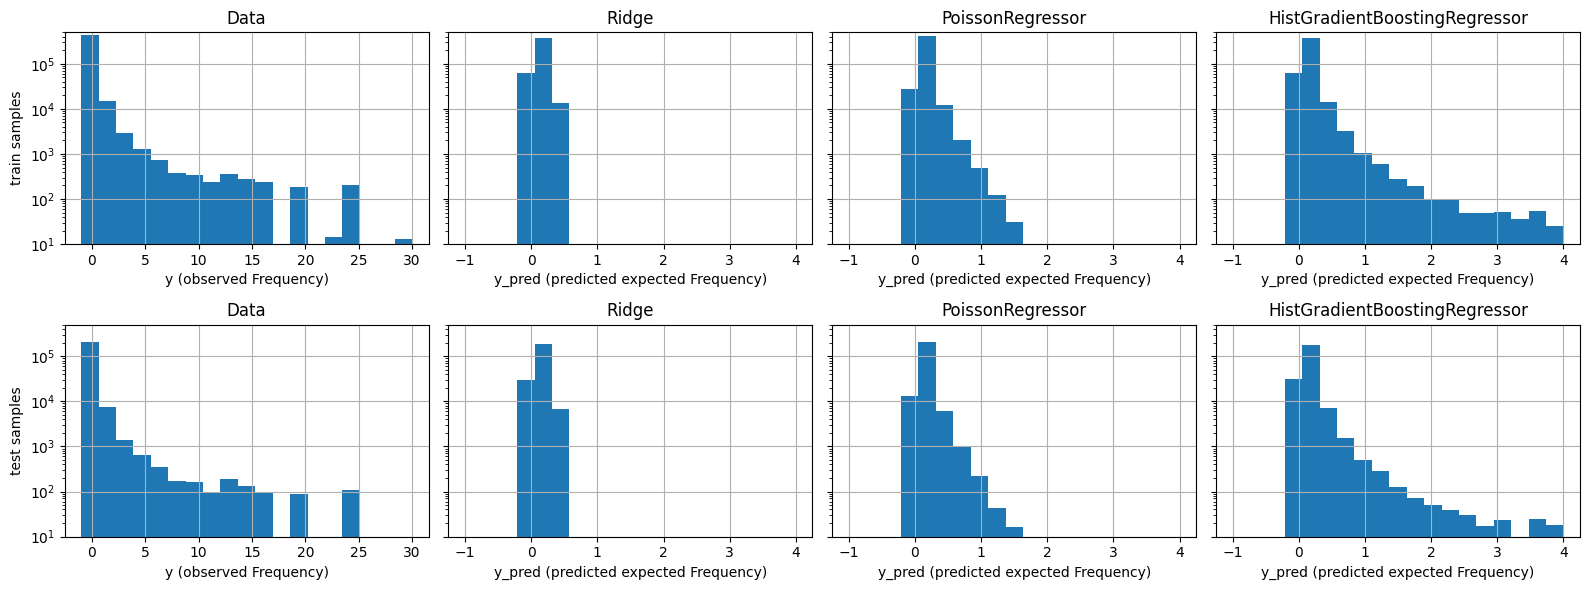

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

The experimental data presents a long tail distribution for ``y``. In all
models, we predict the expected frequency of a random variable, so we will
have necessarily fewer extreme values than for the observed realizations of
that random variable. This explains that the mode of the histograms of model
predictions doesn't necessarily correspond to the smallest value.
Additionally, the normal distribution used in ``Ridge`` has a constant
variance, while for the Poisson distribution used in ``PoissonRegressor`` and
``HistGradientBoostingRegressor``, the variance is proportional to the
predicted expected value.

Thus, among the considered estimators, ``PoissonRegressor`` and
``HistGradientBoostingRegressor`` are a-priori better suited for modeling the
long tail distribution of the non-negative data as compared to the ``Ridge``
model which makes a wrong assumption on the distribution of the target
variable.

The ``HistGradientBoostingRegressor`` estimator has the most flexibility and
is able to predict higher expected values.

Note that we could have used the least squares loss for the
``HistGradientBoostingRegressor`` model. This would wrongly assume a normal
distributed response variable as does the `Ridge` model, and possibly
also lead to slightly negative predictions. However the gradient boosted
trees would still perform relatively well and in particular better than
``PoissonRegressor`` thanks to the flexibility of the trees combined with the
large number of training samples.

## Evaluation of the calibration of predictions

To ensure that estimators yield reasonable predictions for different
policyholder types, we can bin test samples according to ``y_pred`` returned
by each model. Then for each bin, we compare the mean predicted ``y_pred``,
with the mean observed target:



Actual number of claims: 11935
Predicted number of claims by Ridge(alpha=1e-06): 11933.4
Predicted number of claims by PoissonRegressor(alpha=1e-12, solver='newton-cholesky'): 11932.0
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 12163.5
Predicted number of claims by DummyRegressor(): 11931.2


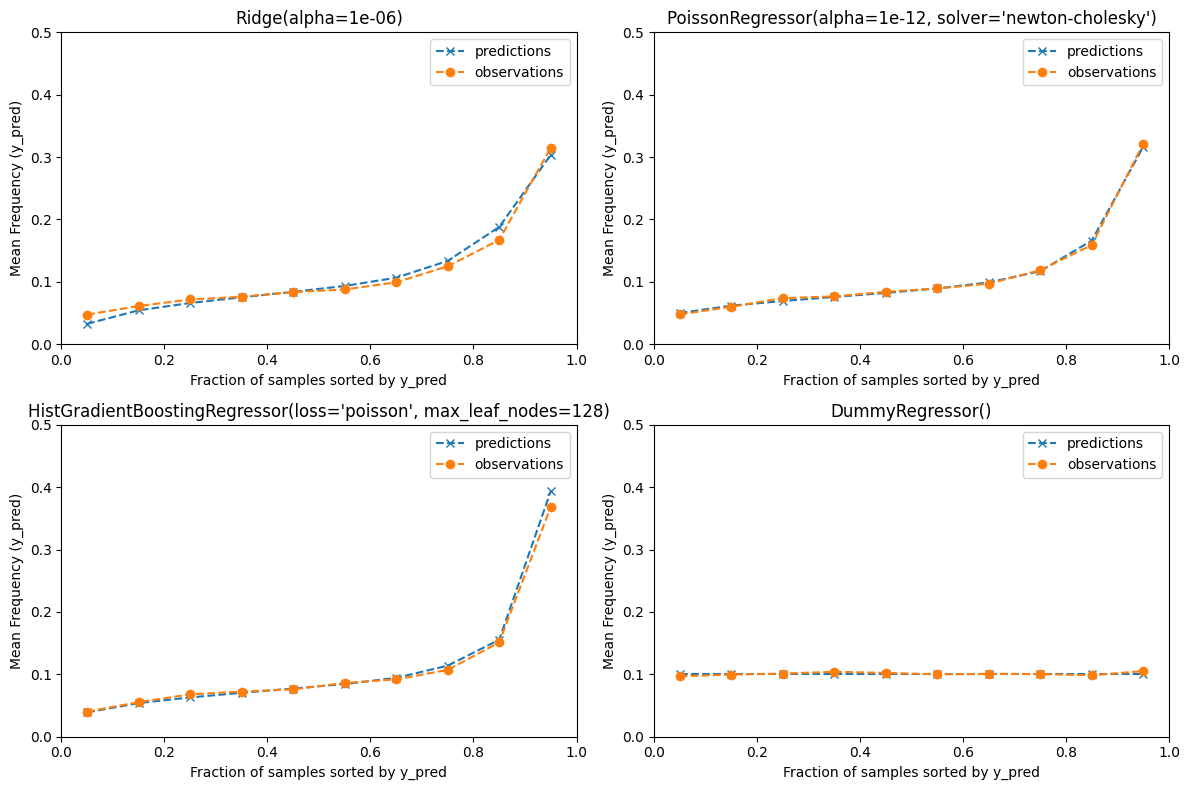

In [13]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

The dummy regression model predicts a constant frequency. This model does not
attribute the same tied rank to all samples but is none-the-less globally
well calibrated (to estimate the mean frequency of the entire population).

The ``Ridge`` regression model can predict very low expected frequencies that
do not match the data. It can therefore severely under-estimate the risk for
some policyholders.

``PoissonRegressor`` and ``HistGradientBoostingRegressor`` show better
consistency between predicted and observed targets, especially for low
predicted target values.

The sum of all predictions also confirms the calibration issue of the
``Ridge`` model: it under-estimates by more than 3% the total number of
claims in the test set while the other three models can approximately recover
the total number of claims of the test portfolio.

## Evaluation of the ranking power

For some business applications, we are interested in the ability of the model
to rank the riskiest from the safest policyholders, irrespective of the
absolute value of the prediction. In this case, the model evaluation would
cast the problem as a ranking problem rather than a regression problem.

To compare the 3 models from this perspective, one can plot the cumulative
proportion of claims vs the cumulative proportion of exposure for the test
samples order by the model predictions, from safest to riskiest according to
each model.

This plot is called a Lorenz curve and can be summarized by the Gini index:



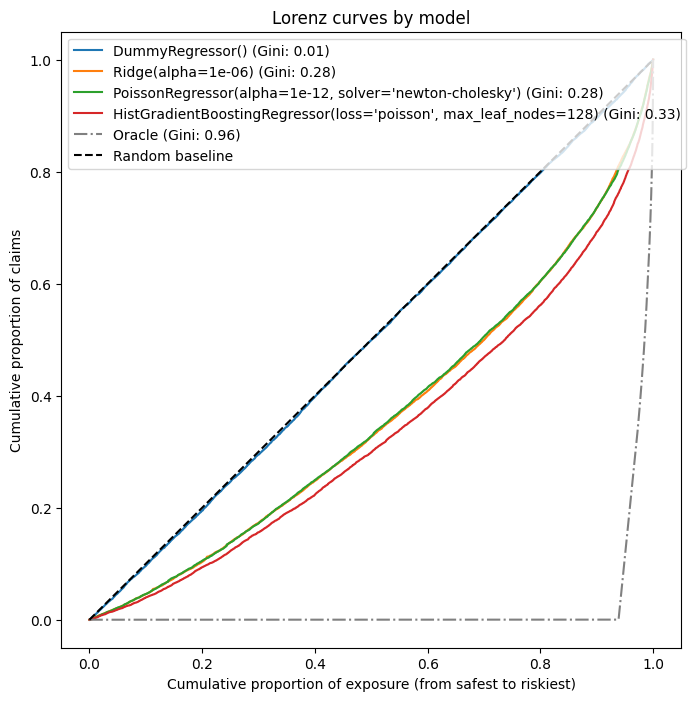

In [14]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(8, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(
        df_test["Frequency"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    df_test["Frequency"], df_test["Frequency"], df_test["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)
ax.legend(loc="upper left")

As expected, the dummy regressor is unable to correctly rank the samples and
therefore performs the worst on this plot.

The tree-based model is significantly better at ranking policyholders by risk
while the two linear models perform similarly.

All three models are significantly better than chance but also very far from
making perfect predictions.

This last point is expected due to the nature of the problem: the occurrence
of accidents is mostly dominated by circumstantial causes that are not
captured in the columns of the dataset and can indeed be considered as purely
random.

The linear models assume no interactions between the input variables which
likely causes under-fitting. Inserting a polynomial feature extractor
(:func:`~sklearn.preprocessing.PolynomialFeatures`) indeed increases their
discrimative power by 2 points of Gini index. In particular it improves the
ability of the models to identify the top 5% riskiest profiles.

## Main takeaways

- The performance of the models can be evaluated by their ability to yield
  well-calibrated predictions and a good ranking.

- The calibration of the model can be assessed by plotting the mean observed
  value vs the mean predicted value on groups of test samples binned by
  predicted risk.

- The least squares loss (along with the implicit use of the identity link
  function) of the Ridge regression model seems to cause this model to be
  badly calibrated. In particular, it tends to underestimate the risk and can
  even predict invalid negative frequencies.

- Using the Poisson loss with a log-link can correct these problems and lead
  to a well-calibrated linear model.

- The Gini index reflects the ability of a model to rank predictions
  irrespective of their absolute values, and therefore only assess their
  ranking power.

- Despite the improvement in calibration, the ranking power of both linear
  models are comparable and well below the ranking power of the Gradient
  Boosting Regression Trees.

- The Poisson deviance computed as an evaluation metric reflects both the
  calibration and the ranking power of the model. It also makes a linear
  assumption on the ideal relationship between the expected value and the
  variance of the response variable. For the sake of conciseness we did not
  check whether this assumption holds.

- Traditional regression metrics such as Mean Squared Error and Mean Absolute
  Error are hard to meaningfully interpret on count values with many zeros.



In [15]:
plt.show()